### Character Recognition Model using CNN
This code demonstrates the implementation of a convolutional neural network (CNN) in building a model for character recognition. The model is trained on a dataset containing images of cropped characters of license plates from (A to Z) and (0 to 9). The goal of the model is to learn to classify the characters in the dataset. The model will be saved and then used to recognize characters from license plates.

#### Import libraries

In [1]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import random

##### The dataset contains images of cropped license plate characters that is from A to Z and 0 to 9. Here we will get class labels (characters) from the subdirectory

In [2]:
# Set the directory path where your dataset is located
data_dir = './dataset'
# Get the list of class labels (characters) from the subdirectory names
class_labels = sorted(os.listdir(data_dir))
num_classes = len(class_labels)
print(num_classes)

35


##### Median height and width of images from the dataset is calculated so that the code can determine the appropriate target size for the imageDataGenerator

In [14]:
# Check the height and width of the images in the dataset
image_heights = []
image_widths = []
for label in class_labels:
    label_dir = os.path.join(data_dir, label)
    for filename in os.listdir(label_dir):
        file_path = os.path.join(label_dir, filename)
        image = Image.open(file_path)
        image_heights.append(image.height)
        image_widths.append(image.width)
        image.close()

# Calculate the median height and width
median_height = np.median(image_heights)
median_width = np.median(image_widths)

# Print the median height and width
print(f"Median image height: {median_height}")
print(f"Median image width: {median_width}")

Median image height: 100.0
Median image width: 75.0


### Handling class imbalance
##### It handles class imbalance, where some classes have significantly more or fewer samples than others, crucially addressing this issue to prevent biased model training.

In [15]:
# Handle class imbalance
class_counts = [len(os.listdir(os.path.join(data_dir, label))) for label in class_labels]
max_count = max(class_counts)
class_weights = {i: max_count / class_counts[i] for i in range(num_classes)}

##### The code displays 5 random images from the dataset. It randomly selects a class label, then chooses a random image file within that class, opens the image, and shows it along with its label. Finally, it closes each image after displaying them.

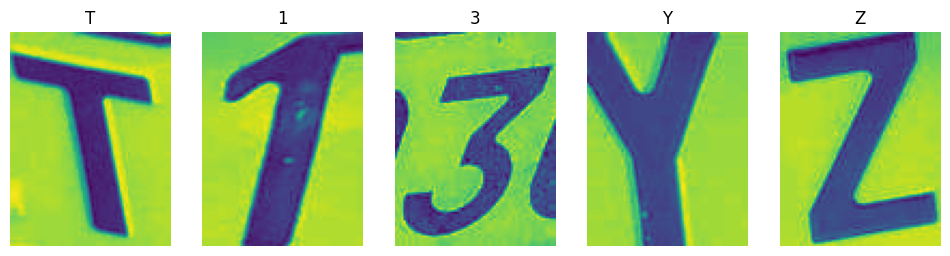

In [21]:
# Display 5 random images from the dataset
plt.figure(figsize=(12, 6))
for i in range(5):
    random_label = random.choice(class_labels)
    random_file = random.choice(os.listdir(os.path.join(data_dir, random_label)))
    file_path = os.path.join(data_dir, random_label, random_file)
    image = Image.open(file_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.title(random_label)
    plt.axis('off')
    image.close()
plt.show()

##### This code preproceses the dataset during training by applying various augmenation techniques that is; rescaling, rotation, shifting, shearing, zooming, and horizontal flipping.

In [22]:
#Preprocess the dataset
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

##### The code compiles a list of image paths and their corresponding labels by iterating through class labels and their respective directories, appending each image and its label index.

In [23]:
# Create a list of all image paths and corresponding labels
all_image_paths = []
all_labels = []
for label_idx, label in enumerate(class_labels):
    label_dir = os.path.join(data_dir, label)
    for filename in os.listdir(label_dir):
        file_path = os.path.join(label_dir, filename)
        all_image_paths.append(file_path)
        all_labels.append(label_idx)

### Stratified splitting
##### The code performs a stratified split of the dataset into training and testing sets, ensuring proportional representation of each class in both sets.

In [45]:
# Perform stratified splitting
stratified_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in stratified_splitter.split(all_image_paths, all_labels):
    train_image_paths = [all_image_paths[i] for i in train_index]
    test_image_paths = [all_image_paths[i] for i in test_index]
    train_labels = [all_labels[i] for i in train_index]
    test_labels = [all_labels[i] for i in test_index]

##### The code creates data generators for training and test data, facilitating batch-wise processing of images. For each generator, it prepares input data by loading images from paths, converting them to RGB format, and pairing them with their corresponding labels. It sets batch size, shuffling, and seed parameters accordingly for training and testing data.

In [31]:
# Create generators for training and test data
train_generator = train_datagen.flow(
    x=np.array([Image.open(path).convert('RGB') for path in train_image_paths]),
    y=np.array(train_labels),
    batch_size=32,
    shuffle=True,
    seed=42
)

test_generator = train_datagen.flow(
    x=np.array([Image.open(path).convert('RGB') for path in test_image_paths]),
    y=np.array(test_labels),
    batch_size=32,
    shuffle=False,
    seed=42
)

##### The code constructs a Convolutional Neural Network (CNN) model. It sequentially adds layers to the model, including convolutional layers with relu activation, max pooling layers for downsampling, flattening layer to convert 2D feature maps into a 1D vector, dense layers with relu activation, dropout layers for regularization, and a final dense layer with softmax activation for multi-class classification.

In [32]:
# Build the CNN model
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(int(median_height), int(median_width), 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='softmax'))

C:\Users\HomePC\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


##### The code compiles the CNN model with specified optimizer and loss, trains it with early stopping and learning rate reduction callbacks, and evaluates its performance on test data.

In [33]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

history = model.fit(train_generator,
                   epochs=50,
                   validation_data=test_generator,
                   callbacks=[early_stopping, reduce_lr],
                   class_weight=class_weights)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")

Epoch 1/50


C:\Users\HomePC\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


888/888 ━━━━━━━━━━━━━━━━━━━━ 408s 456ms/step - accuracy: 0.0948 - loss: 3.2634 - val_accuracy: 0.4969 - val_loss: 1.6384 - learning_rate: 0.0010
Epoch 2/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 389s 438ms/step - accuracy: 0.4542 - loss: 1.7213 - val_accuracy: 0.7142 - val_loss: 0.9705 - learning_rate: 0.0010
Epoch 3/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 382s 430ms/step - accuracy: 0.6134 - loss: 1.1962 - val_accuracy: 0.7908 - val_loss: 0.7016 - learning_rate: 0.0010
Epoch 4/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 382s 429ms/step - accuracy: 0.6936 - loss: 0.9463 - val_accuracy: 0.8275 - val_loss: 0.5460 - learning_rate: 0.0010
Epoch 5/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 385s 433ms/step - accuracy: 0.7451 - loss: 0.8010 - val_accuracy: 0.8649 - val_loss: 0.4412 - learning_rate: 0.0010
Epoch 6/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 390s 438ms/step - accuracy: 0.7751 - loss: 0.6936 - val_accuracy: 0.8880 - val_loss: 0.3703 - learning_rate: 0.0010
Epoch 7/50
888/888 ━━━━━━━━━━━━━━━━━━━━ 389s 438ms/step - accuracy: 0.8010 

##### The code obtains predicted labels for the test data by using the trained model to make predictions via the test generator.

In [34]:
# Get the predicted labels for the test data
test_predictions = model.predict(test_generator)

222/222 ━━━━━━━━━━━━━━━━━━━━ 28s 124ms/step


##### The code converts the test labels to a NumPy array for further analysis.

In [35]:
# Convert test labels to a numpy array
test_labels_np = np.array(test_labels)

##### The code computes the confusion matrix using the true test labels and the predicted labels, then prints out the resulting matrix.

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(test_labels_np, test_predictions.argmax(axis=1))
print("Confusion Matrix:")
print(cm)

##### The code computes the classification report, which includes metrics such as precision, recall, and F1-score, and prints it out. This report provides a detailed evaluation of the model's performance for each class.

In [37]:
# Compute the classification report
report = classification_report(test_labels_np, test_predictions.argmax(axis=1), target_names=class_labels)
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       206
           1       0.98      0.97      0.97       206
           2       0.98      0.98      0.98       206
           3       0.99      0.98      0.98       206
           4       1.00      0.99      1.00       206
           5       0.99      0.97      0.98       206
           6       0.99      0.98      0.99       206
           7       0.98      0.96      0.97       206
           8       0.96      0.99      0.97       206
           9       0.99      0.99      0.99       206
           A       1.00      1.00      1.00       202
           B       0.98      0.95      0.96       206
           C       0.96      0.93      0.94       204
           D       0.98      0.96      0.97       202
           E       0.98      0.93      0.95       202
           F       0.93      0.98      0.96       204
           G       0.99      1.00      0.99       204
    

##### The code computes the Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) for each class. It iterates through each class, calculating the false positive rate (FPR), true positive rate (TPR), and AUC using the `roc_curve` and `auc` functions.

In [38]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_np, test_predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

##### The code computes the macro-averaged ROC curve and the corresponding Area Under the Curve (AUC) by averaging the true positive rates (TPRs) across all classes. It interpolates the TPRs for each class at a unique set of false positive rates (FPRs) and then calculates the mean TPR and AUC.

In [40]:

# Compute macro-averaged ROC curve and ROC area
# Get all unique false positive rates across all classes
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
# Initialize an array to hold the interpolated true positive rates
mean_tpr = np.zeros_like(all_fpr)
# Interpolate all ROC curves at these points
for i in range(num_classes):
    # Add the interpolated true positive rate for class i
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# Average the true positive rates by the number of classes
mean_tpr /= num_classes
# Compute the AUC for the macro-averaged ROC curve
mean_auc = auc(all_fpr, mean_tpr)



##### The code plots the macro-averaged Receiver Operating Characteristic (ROC) curve, displaying the relationship between the false positive rate (FPR) and the true positive rate (TPR). It also includes a dashed line representing random guessing.

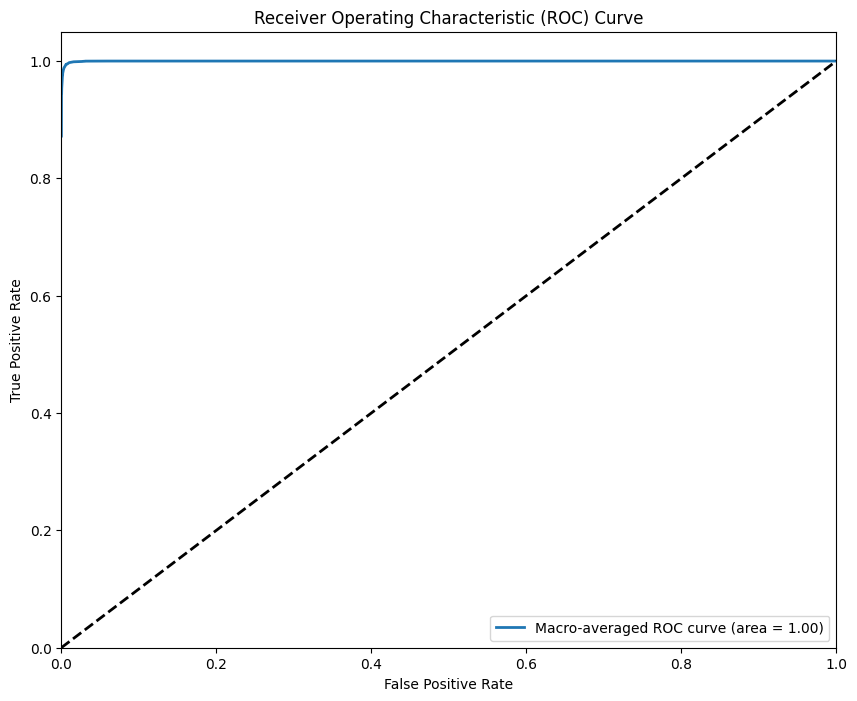

In [41]:
# Plot the macro-averaged ROC curve
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(all_fpr, mean_tpr, lw=lw,
         label='Macro-averaged ROC curve (area = {0:0.2f})'.format(mean_auc))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

##### The code computes the confusion matrix using the true test labels and the predicted labels, then prints out the resulting matrix.

In [42]:
# Compute the confusion matrix
cm = confusion_matrix(test_labels_np, test_predictions.argmax(axis=1))
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[196   1   1 ...   0   0   0]
 [  0 200   0 ...   0   0   0]
 [  0   1 201 ...   0   0   1]
 ...
 [  0   0   0 ... 197   4   0]
 [  0   0   0 ...   0 195   0]
 [  0   0   2 ...   0   0 153]]


### Confusion matrix
##### This code segment computes and prints the confusion matrix, followed by a visualization of the confusion matrix as a heatmap. Each cell in the heatmap represents the count of true positives for a given combination of true and predicted classes. Text annotations show the count values, and the color intensity indicates the magnitude of the counts.

Confusion Matrix:
[[196   1   1 ...   0   0   0]
 [  0 200   0 ...   0   0   0]
 [  0   1 201 ...   0   0   1]
 ...
 [  0   0   0 ... 197   4   0]
 [  0   0   0 ...   0 195   0]
 [  0   0   2 ...   0   0 153]]


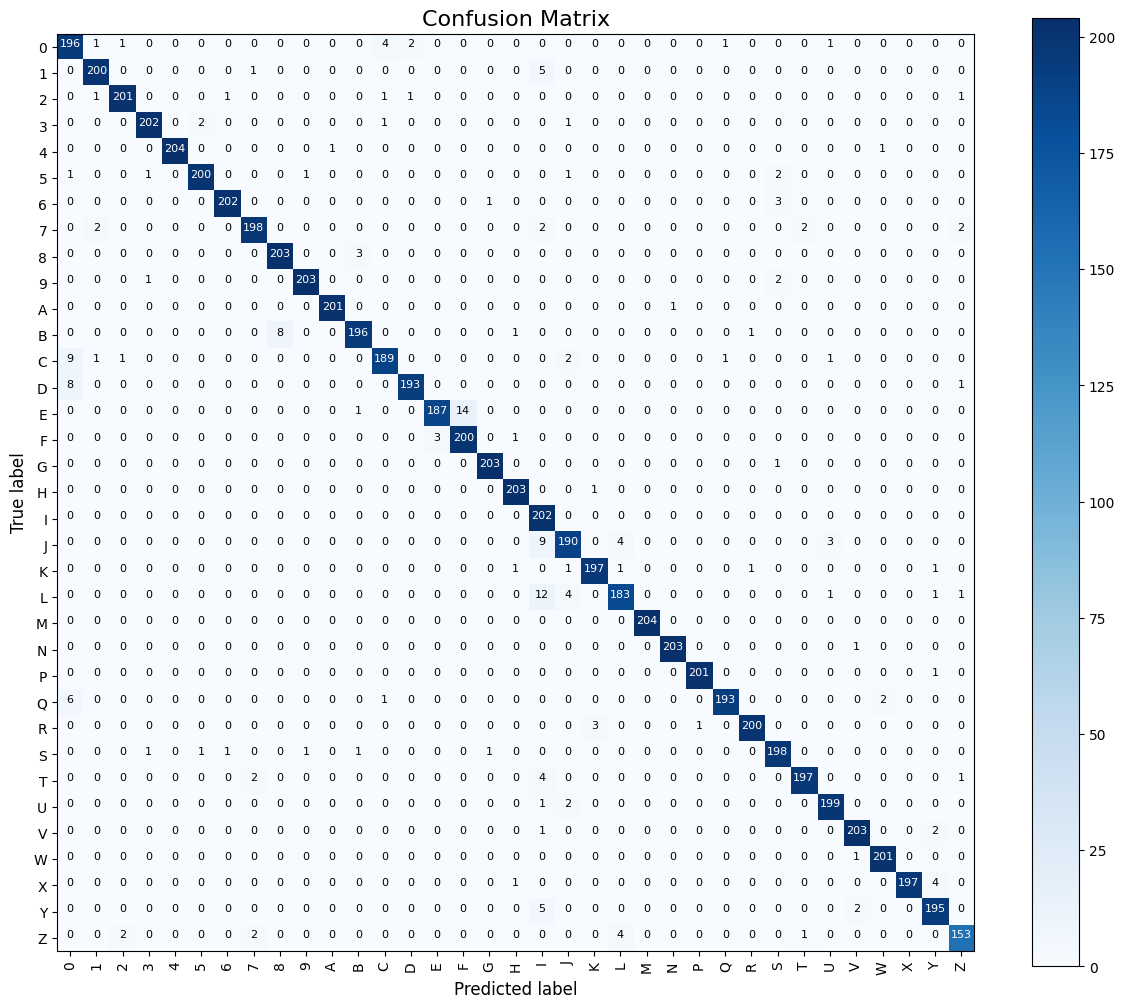

In [43]:
import itertools
# import matplotlib.pyplot as plt
# import numpy as np

# Compute the confusion matrix
cm = confusion_matrix(test_labels_np, test_predictions.argmax(axis=1))
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))  # Set the figure size
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)  # Display the confusion matrix
plt.title('Confusion Matrix', fontsize=16)  # Add a title
plt.colorbar()  # Add a color bar
tick_marks = np.arange(num_classes)  # Create tick marks for the axes
plt.xticks(tick_marks, class_labels, rotation=90, fontsize=10)  # Set x-axis labels
plt.yticks(tick_marks, class_labels, fontsize=10)  # Set y-axis labels

fmt = 'd'  # Format for displaying cell values (decimal integer)
thresh = cm.max() / 2.  # Threshold for text color (half of the maximum value)

# Add text to each cell of the matrix
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black",
             fontsize=8)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.ylabel('True label', fontsize=12)  # Set y-axis label
plt.xlabel('Predicted label', fontsize=12)  # Set x-axis label
plt.show()  # Display the plot


##### The code saves the trained model to the specified path. After saving, it prints a message confirming the successful saving of the model.

In [44]:
# Save the model
model.save("./saved_models/model_char_recognition.keras")
print("Model saved successfully")

Model saved successfully
